In [1]:
import scipy.io as sio
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import truncnorm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import data_generator
import ESPRIT
import QPE
import QCELS
import GFAS

In [2]:
def generate_ts_distribution(T,N,gamma):
    """ Generate time samples from truncated Gaussian
    Input:
    
    T : variance of Gaussian
    gamma : truncated parameter
    N : number of samples
    
    Output: 
    
    t_list: np.array of time points
    """
    t_list=truncnorm.rvs(-gamma, gamma, loc=0, scale=T, size=N)
    return t_list

def generate_Z(spectrum,population,T,N,gamma):
    """ Generate Z samples for a given T,N,gamma
    Input:
    
    spectrum: np.array of eigenvalues
    population: np.array of overlap
    T : variance of Gaussian
    N : number of time samples
    gamma : truncated parameter
    
    Output: 
    
    Z_est: np.array of Z output
    t_list: np.array of time points
    T_max: maximal running time
    T_total: total running time
    """
    t_list = generate_ts_distribution(T,N,gamma)
    N_list = np.ones(len(t_list))
    T_max = max(np.abs(t_list))
    T_total = sum(np.multiply(np.abs(t_list),N_list))
    Z_est, _ , _ =data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
    return Z_est, t_list, T_max, T_total

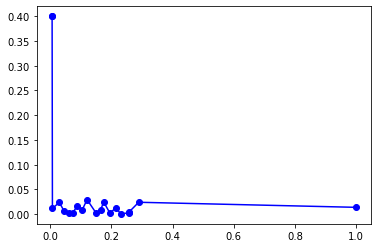

In [3]:
#Test random H
gap_list=np.array([0.001,0.001])
p_list=np.array([0.4,0.4])
d=20
spectrum, population=data_generator.generate_random_Hamiltonian(gap_list,p_list,d)

In [4]:
N_rep=10 #number of different trying
N_rep_ESPRIT=5
spectrum_per=np.zeros((len(spectrum),N_rep))
for n in range(N_rep):
   #random perturb to avoid coincidence
   spectrum_per[:,n]=spectrum+np.random.uniform(-1,1)*0.05

# Test GFAS

In [5]:
T_list=np.array([100,200,400,800,1600,3200,6400,12800])
N=500
K=2
alpha=5
gamma=1
error_GFAS=np.zeros(len(T_list),dtype='float')
T_total_GFAS=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    for k in range(len(T_list)):
        T_max=T_list[k]
        d_x=0.05/T_max
        Z_est,t_list, _, T_total = generate_Z(spectrum_per[:,n],population,T_max,N,gamma)
        T_total_GFAS[k]+=sum(np.abs(t_list))
        output_energy = GFAS.GFAS_new(Z_est, d_x, t_list, K, alpha, T_max)
        output_energy = np.sort(output_energy)
        ##---measure error--##
        index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
        dominant_energy=np.zeros(K,dtype=float)
        dominant_weight=np.zeros(K,dtype=float)
        error_temp=0
        for l in range(K):
                dominant_energy[l]=spectrum_per[index_list[l],n]
                error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        error_GFAS[k]+=error_temp
        if n==0:
            print('Tmax=',gamma*T_max)
            print('Output of GFAS energy=',output_energy)
            print('True dominant=',np.sort(dominant_energy))
T_total_GFAS=T_total_GFAS/N_rep
error_GFAS=error_GFAS/N_rep

Tmax= 100
Output of GFAS energy= [-1.62559265 -0.01809265]
True dominant= [-0.01652353 -0.01549511]
Tmax= 200
Output of GFAS energy= [-0.47159265 -0.01584265]
True dominant= [-0.01652353 -0.01549511]
Tmax= 400
Output of GFAS energy= [-0.01559265  0.16178235]
True dominant= [-0.01652353 -0.01549511]
Tmax= 800
Output of GFAS energy= [-0.01615515  2.41784485]
True dominant= [-0.01652353 -0.01549511]
Tmax= 1600
Output of GFAS energy= [-0.01596765  1.00009485]
True dominant= [-0.01652353 -0.01549511]
Tmax= 3200
Output of GFAS energy= [-0.82632703 -0.01601453]
True dominant= [-0.01652353 -0.01549511]
Tmax= 6400
Output of GFAS energy= [-0.01661609 -0.01544422]
True dominant= [-0.01652353 -0.01549511]
Tmax= 12800
Output of GFAS energy= [-0.01653406 -0.01546765]
True dominant= [-0.01652353 -0.01549511]


# Test QPE

In [6]:
N_QPE=30
error_QPE=np.zeros(len(T_list),dtype='float')
T_total_QPE=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    for k in range(len(T_list)):
        T_max=T_list[k]
        output_energy = QPE.QPE(spectrum_per[:,n],population,T_max,N_QPE)
        T_total_QPE[k]+=T_max*N_QPE
        ##---measure error--##
        error_QPE[k]+=np.abs(spectrum_per[0,n]-output_energy)
        if n==0:
            print('Tmax=',T_max)
            print('Output of QPE energy=',output_energy)
            print('True ground=',spectrum_per[0,n])        
T_total_QPE=T_total_QPE/N_rep
error_QPE=error_QPE/N_rep

Tmax= 100
Output of QPE energy= -0.7539822368615505
True ground= -0.016523529725028453
Tmax= 200
Output of QPE energy= -2.230530784048753
True ground= -0.016523529725028453
Tmax= 400
Output of QPE energy= -0.015707963267948877
True ground= -0.016523529725028453
Tmax= 800
Output of QPE energy= -0.015707963267948877
True ground= -0.016523529725028453
Tmax= 1600
Output of QPE energy= -0.015707963267948877
True ground= -0.016523529725028453
Tmax= 3200
Output of QPE energy= -0.027488935718910756
True ground= -0.016523529725028453
Tmax= 6400
Output of QPE energy= -0.017671458676442597
True ground= -0.016523529725028453
Tmax= 12800
Output of QPE energy= -0.017671458676442597
True ground= -0.016523529725028453


# Test ESPRIT

In [7]:
t_list=np.arange(max(T_list))
N_list=np.ones(len(t_list))
K_ESPRIT=2
K_dominant=2
nt_array=T_list
error_ESPRIT=np.zeros(len(nt_array),dtype='float')
T_total_ESPRIT=np.zeros(len(T_list),dtype='float')
for n in range(N_rep_ESPRIT):
    f_values,_,_=data_generator.generate_Hadamard_test_data(spectrum_per[:,n],
    population,t_list,N_list)
    for k in range(len(nt_array)):
        dt=1
        nt_effective=nt_array[k]
        #ESPRIT
        output_energy = ESPRIT.ESPRIT(f_values[:nt_effective], int(nt_effective/2), nt_effective, K_ESPRIT)
        T_total_ESPRIT[k]+=nt_effective*(nt_effective+1)/2
        ##---measure error--##
        index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        for l in range(K):
            dominant_energy[l]=spectrum_per[index_list[l],n]
            error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        error_ESPRIT[k]+=error_temp
        if n==0:
            print('Tmax=',nt_effective*dt)
            print('Output of ESPRIT energy=',output_energy)
            print('True dominant=',np.sort(dominant_energy))
T_total_ESPRIT=T_total_ESPRIT/N_rep_ESPRIT
error_ESPRIT=error_ESPRIT/N_rep_ESPRIT

Tmax= 100
Output of ESPRIT energy= [-0.01683349  2.01368951]
True dominant= [-0.01652353 -0.01549511]
Tmax= 200
Output of ESPRIT energy= [-0.01562998  2.40064645]
True dominant= [-0.01652353 -0.01549511]
Tmax= 400
Output of ESPRIT energy= [-0.01622419  2.44235994]
True dominant= [-0.01652353 -0.01549511]
Tmax= 800
Output of ESPRIT energy= [-0.01563988  1.33935266]
True dominant= [-0.01652353 -0.01549511]
Tmax= 1600
Output of ESPRIT energy= [-0.01606206  2.76122603]
True dominant= [-0.01652353 -0.01549511]
Tmax= 3200
Output of ESPRIT energy= [-0.01607865  1.88490841]
True dominant= [-0.01652353 -0.01549511]
Tmax= 6400
Output of ESPRIT energy= [-0.01645058 -0.01558217]
True dominant= [-0.01652353 -0.01549511]
Tmax= 12800
Output of ESPRIT energy= [-0.01653084 -0.01549487]
True dominant= [-0.01652353 -0.01549511]


# Test QCELS

In [8]:
def spectrum_organize(Output_QCELS): #combine opposite r but same \theta
    dis_threshold=0.01
    L=len(Output_QCELS)
    L=int(L/3)
    index_list=np.zeros(L, dtype='float')
    weight_rearrange=np.zeros(L, dtype='complex')
    indicator=np.zeros(L, dtype='float')
    for l in range(L): #combine eigenvalues with oppposite weight
        if indicator[l]==0:
           weight_rearrange[l]=Output_QCELS[3*l]+1j*Output_QCELS[3*l+1]
           fix_energy_check=Output_QCELS[3*l+2]
           for j in range(l+1,L): 
               if np.abs(Output_QCELS[3*j+2]-fix_energy_check)<dis_threshold:
                  weight_rearrange[l]+=Output_QCELS[3*j]+1j*Output_QCELS[3*j+1]
                  indicator[j]=1
        indicator[l]=1
        weight_rearrange[l]=np.abs(weight_rearrange[l])
    index_list=sorted(range(L),key= lambda k:weight_rearrange[k], reverse=True)
    dominant_energy=np.zeros(L, dtype='float')
    for l in range(L):
        dominant_energy[l]=Output_QCELS[3*index_list[l]+2]
    return dominant_energy

In [9]:
N_0 = 1000 #N_0
N = 500 #N
gamma=1
K_QCELS=2
T_total_QCELS=np.zeros(len(T_list),dtype='float')
error_QCELS=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    for k in range(len(T_list)):
        T = T_list[k]
        T_0 = 100
        dominant_energy_estimate=np.zeros(K_QCELS)
        Output_QCELS, _, T_total = \
                 QCELS.qcels_multimodal(spectrum_per[:,n], population, T_0, T, N_0, N, gamma, K_QCELS, spectrum_per[0:2,n])#QCELS with time T
        output_energy=np.sort(spectrum_organize(Output_QCELS))
        T_total_QCELS[k]+=T_total
        ##---measure error--##
        index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        for l in range(K):
            dominant_energy[l]=spectrum_per[index_list[l],n]
            error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        error_QCELS[k]+=error_temp
        if n==0:
            print('Tmax=',gamma*T)
            print('Output of QCELS energy=',output_energy)
            print('True dominant=',np.sort(dominant_energy))
T_total_QCELS=T_total_QCELS/N_rep
error_QCELS=error_QCELS/N_rep

Tmax= 100
Output of QCELS energy= [-0.01596332  0.37268036]
True dominant= [-0.01652353 -0.01549511]
Tmax= 200
Output of QCELS energy= [-0.0168342  -0.01627103]
True dominant= [-0.01652353 -0.01549511]
Tmax= 400
Output of QCELS energy= [-0.01586699  0.16806214]
True dominant= [-0.01652353 -0.01549511]
Tmax= 800
Output of QCELS energy= [-0.01608269  0.84388569]
True dominant= [-0.01652353 -0.01549511]
Tmax= 1600
Output of QCELS energy= [-0.01605171  0.90050305]
True dominant= [-0.01652353 -0.01549511]
Tmax= 3200
Output of QCELS energy= [-0.01595425  0.70021664]
True dominant= [-0.01652353 -0.01549511]
Tmax= 6400
Output of QCELS energy= [-0.0154321   0.98332684]
True dominant= [-0.01652353 -0.01549511]
Tmax= 12800
Output of QCELS energy= [-0.01652903 -0.01550588]
True dominant= [-0.01652353 -0.01549511]


/Users/zhiyan_ding/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


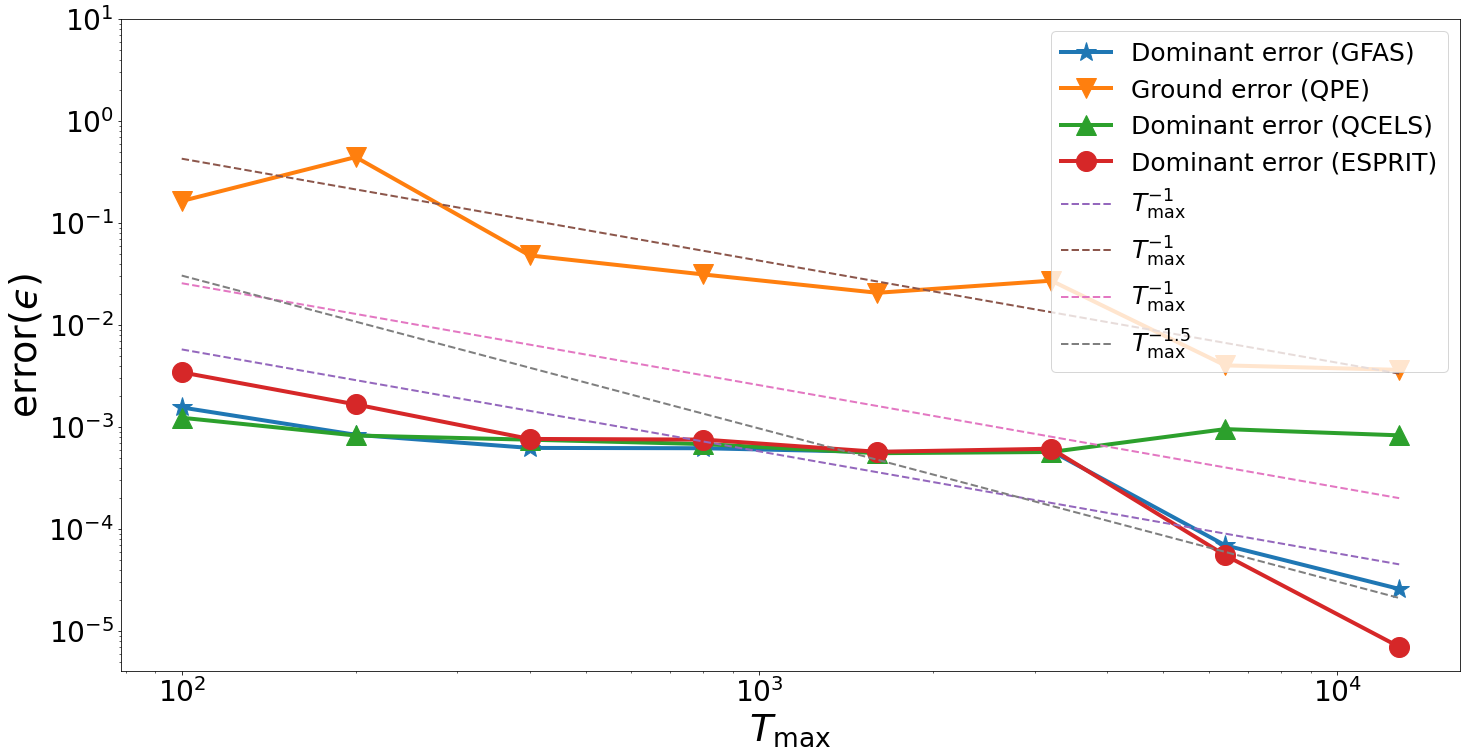

In [10]:
# Plotting the real and imaginary parts of f(t)
T_list=dt*nt_array
plt.figure(figsize=(24, 12))
plt.loglog(T_list, error_GFAS, marker="*",markersize=20,
           linewidth=4, label='Dominant error (GFAS)')
plt.loglog(T_list, error_QPE, marker="v",markersize=20,
            linewidth=4, label='Ground error (QPE)')
plt.loglog(T_list, error_QCELS, marker="^",markersize=20,
           linewidth=4, label='Dominant error (QCELS)')
plt.loglog(T_list, error_ESPRIT, marker="o",markersize=20,
           linewidth=4, label='Dominant error (ESPRIT)')
plt.loglog(T_list, np.dot(error_GFAS,T_list)/T_list/len(error_GFAS), 
           '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_QPE,T_list)/T_list/len(error_QPE), 
            '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_QCELS,T_list)/T_list/len(error_QCELS),
           '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_ESPRIT[1:],T_list[1:]**1.5)/T_list**1.5/len(error_ESPRIT[1:]), 
           '--', linewidth=2, label=r'$T_{\max}^{-1.5}$')
plt.xlabel("$T_{\max}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25,loc="upper right")

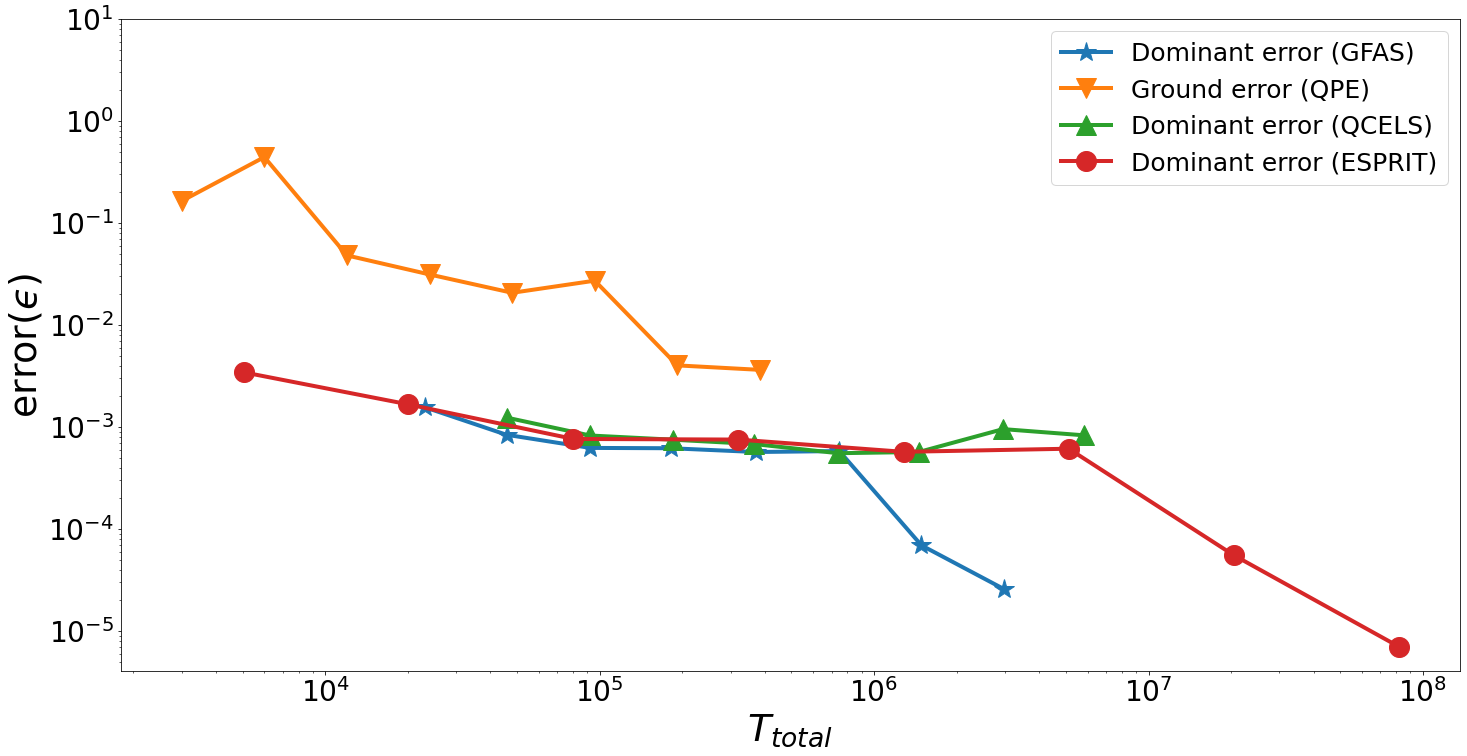

In [11]:
# Plotting the real and imaginary parts of f(t)
T_list=dt*nt_array
plt.figure(figsize=(24, 12))
plt.loglog(T_total_GFAS, error_GFAS, marker="*",markersize=20,
           linewidth=4, label='Dominant error (GFAS)')
plt.loglog(T_total_QPE, error_QPE, marker="v",markersize=20,
            linewidth=4, label='Ground error (QPE)')
plt.loglog(T_total_QCELS, error_QCELS, marker="^",markersize=20,
           linewidth=4, label='Dominant error (QCELS)')
plt.loglog(T_total_ESPRIT, error_ESPRIT, marker="o",markersize=20,
           linewidth=4, label='Dominant error (ESPRIT)')
plt.xlabel("$T_{total}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25)